In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Single Time Series Forecasting

### Load Data

In [3]:
def load_data():
    daily_new_cases = None
    
    df = pd.read_csv('Data/time_series_covid19_confirmed_global.csv')
    df = df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
    
    
    total_cases = df.sum(axis=0)
    
    daily_new_cases = total_cases.diff().dropna()
    
    daily_new_cases.index = pd.to_datetime(daily_new_cases.index)

    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return daily_new_cases

### Stationarity Tests
Let's first try to understand whether our time series is stationary or not. Recall that a stationary time series has stable statistics, such as constant means and variances, over time. 

The function below that takes as input a time series and that calculates the rolling mean and the rolling standard deviation of the input time series. The size of the rolling window is governed by the argument wd_size.

In [20]:
def calc_rolling_stats(ser, wd_size=7):
    
  
    n = len(ser)
    ## they both have the same length as the ser
    rolling_mean = np.zeros(n)
    rolling_std = np.zeros(n)
   

    for j in range(n):
        if j == 0:
            rolling_mean[j] = ser[0]
            rolling_std[j] = 0
        elif j < wd_size:
            rolling_mean[j] = np.mean(ser[:j+1])
            rolling_std[j] = np.sqrt(np.mean((ser[:j+1] - rolling_mean[j]) ** 2))
        else:
            rolling_mean[j] = np.mean(ser[j-wd_size+1:j+1])
            rolling_std[j] = np.sqrt(np.mean((ser[j-wd_size+1:j+1] - rolling_mean[j]) ** 2))  ## using the mathmatical formula to manully calculate the rolling mean and Std
    
    return rolling_mean, rolling_std

Let's plot and see the rolling statistics together with the original time series. Is our time series stationary?

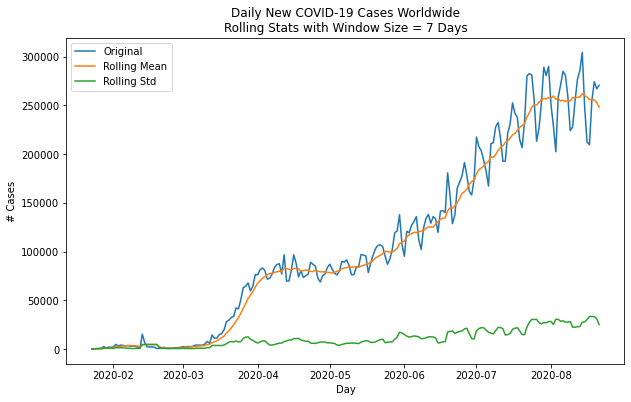

In [21]:
ser, wd_size = load_data(), 7
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(pd.Series(rolling_mean, index=ser.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=ser.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, ser, wd_size, rolling_mean, rolling_std

The time series does not appear to be stationary due to the presence of a clear upward trend in both the original data and its rolling mean. For a time series to be considered stationary, it should have constant statistical properties over time, meaning that the mean, variance, and covariance should be consistent. In this case, the increasing trend indicates that the mean is not constant over time.

Now let's see whether the log return of our time series is stationary.

The function below that computes the log return of a given time series and that returns the result as a pd.Series.

In [22]:
def calc_log_ret(ser):

 
    log_ret = np.log(ser / ser.shift(1))
    
    log_ret = log_ret.dropna()
   
    
    return log_ret

This time let's plot and see the rolling statistics together with the log returns. Are the log returns of our time series stationary? 

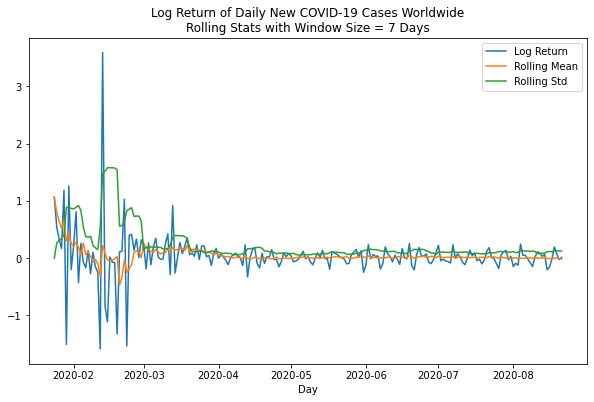

In [23]:
log_ret, wd_size = calc_log_ret(load_data()), 7
rolling_mean, rolling_std = calc_rolling_stats(log_ret, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_ret, label="Log Return")
ax.plot(pd.Series(rolling_mean, index=log_ret.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=log_ret.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_title("Log Return of Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, log_ret, wd_size, rolling_mean, rolling_std

The log returns of the time series appear to be stationary. The data doesn't display any noticeable trend or seasonality, and both the rolling mean and the rolling standard deviation remain relatively stable over time.

Yet another way of determining stationarity would be to use a statistical test, such as the Augmented Dickey-Fuller unit root test. The null hypothesis is usually that the time series is non-stationary. A p-value less than 0.05 would lead to the conclusion that the time series is stationary.

As you can see below the calculated p-value of a given original time series indeicates that the time series is not stationary.

In [24]:
from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(load_data())
print(f"p-value: {pval}")

del adfuller, pval

p-value: 0.6765852511544103


### Autocorrelations
           Observations in a time series are often not isolated but rather correlated. That is, there might be a correlation between an observation  y(t) and another observation  y(t-k) that is  time steps (or lags) earlier. (Partial) autocorrelations precisely capture this idea.

The function below to calculate the Autocorrelation Function (ACF) of the input time series, with the maximum number of lags to consider specified by the parameter max_lag. 

In [25]:
from statsmodels.tsa.stattools import acf
def calc_acf(ser, max_lag):
   
    
    ans_acf = acf(ser, nlags=max_lag, fft=True)
    
    return ans_acf

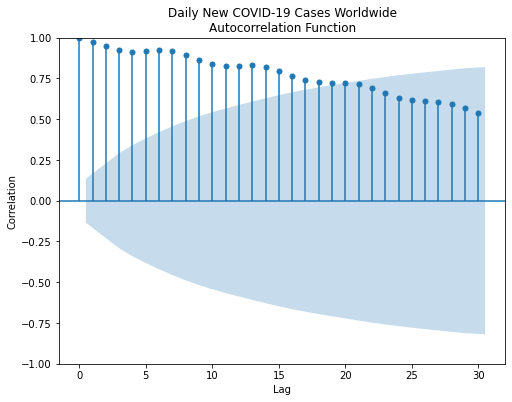

In [26]:
## Let's see the plot of the ACF
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

The function below to calculate the Partial Autocorrelation Function (PACF) of the input time series, with the maximum number of lags to consider specified by the parameter max_lag.

In [27]:
from statsmodels.tsa.stattools import pacf
def calc_pacf(ser, max_lag):
  
    
    ans_pacf = pacf(ser, nlags=max_lag, method = "yw")
    

    
    return ans_pacf

c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


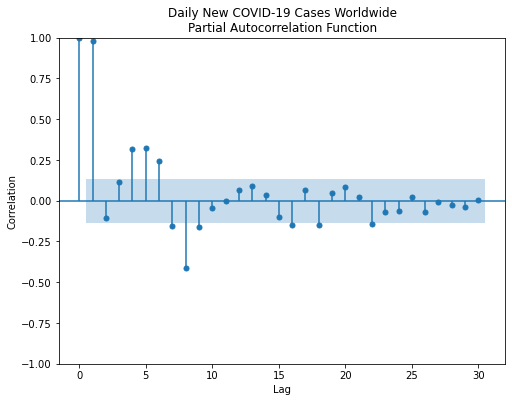

In [28]:
## let's plot the PACF 
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

### ARMA on Log Returns
     

The function below fits an ARMA model on the log return of an input series. 

In [29]:
from statsmodels.tsa.arima.model import ARIMA

def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    
    # Calculate the log return of the series
    log_return = np.log(ser).diff().dropna()
    
    # Fit ARIMA model
    model = ARIMA(log_return, order=(p, 1, q))
    results = model.fit()
    
    # Forecast using the model
    forecasted_log_return = results.forecast(steps=num_forecasts)
    
    # Convert the forecasted log return back to the original data space
    last_val = ser.iloc[-1]
    forecasts = []
    for forecasted_return in forecasted_log_return:
        forecast_val = last_val * np.exp(forecasted_return)
        forecasts.append(forecast_val)
        last_val = forecast_val
    
    # Create the forecasted series
    forecast_index = pd.date_range(start=ser.index[-1] + pd.Timedelta(days=1), periods=num_forecasts, freq='D')
    forecasts_series = pd.Series(forecasts, index=forecast_index, name='predicted_mean')
 
    #HINT: set order for ARIMA model to p, 1, q   
    

    return forecasts_series

c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\qfu88\AppData\Local\Temp\ipykernel_15680\1964373974.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a f

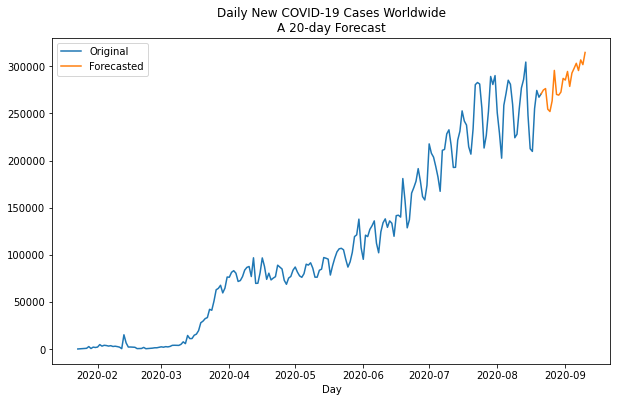

In [32]:
## let's plot and compare the original time series, the forecasts and the ground-truth values of the forecasts

ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_log_ret(ser, p, q, num_forecasts)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")


ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts

### ARMA on First-order Differences

The function below fits an ARMA model on the first-order differences of an input time series. 

In [33]:
from statsmodels.tsa.arima.model import ARIMA

def arma_first_diff(ser, p, q, num_forecasts):
     
    # Fit ARIMA model on first-order differences
    model = ARIMA(ser, order=(p, 1, q))
    results = model.fit()
    
    # Forecast using the model
    forecasted_diff = results.forecast(steps=num_forecasts)
    
    # Convert the forecasted differences back to the original data space
    last_val = ser.iloc[-1]
    forecasts = [last_val + forecasted_diff[0]]
    for i in range(1, num_forecasts):
        forecasts.append(forecasts[i-1] + forecasted_diff[i])
    
    # Create the forecasted series
    forecast_index = pd.date_range(start=ser.index[-1] + pd.Timedelta(days=1), periods=num_forecasts, freq='D')
    forecasts_series = pd.Series(forecasts, index=forecast_index, name='predicted_mean')
    
    return forecasts_series

## Multiple Time Series Forecasting

### Load Data

In [36]:
def load_data():
    daily_new_cases = None
    
    df = pd.read_csv('Data/time_series_covid19_confirmed_global.csv')
    df = df.drop(columns=['Province/State', 'Lat', 'Long']).groupby('Country/Region').sum()

    # Transpose the dataframe so dates are rows
    df = df.T
    #covert index
    df.index = pd.to_datetime(df.index)
    #filter
    df = df[(df.index >= '2020-01-23') & (df.index <= '2020-08-21')]


    # Get the top 5 countries 
    top5_countries = df.loc['2020-08-21'].nlargest(5).index.tolist()

    # Filter only top5
    df = df[top5_countries]

    daily_new_cases = df.diff()
    daily_new_cases.iloc[0] = 0
    
    
    return daily_new_cases

### Vector Autoregression (VAR)

There may be interesting relationships that exist among multiple time series. One way of uncovering such relationships is to perform a VAR, where we model a time series not only with its own observations but also observations from other possibly related time series

The function below fits a VAR model on the first-order differences of multiple input time series given as a "DataFrame" and that makes forecasts in the original data space. 

In [84]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """

    
    # Create first-order difference data
    df_diff = df.diff().dropna()
    
    # Fit the VAR model on the differenced data
    model = VAR(df_diff)
    var_res = model.fit(p)
    
    
    forecast_diff = var_res.forecast(df_diff.values[-p:], steps=num_forecasts)
    
    # Convert the first-order differences back to the original scale
    # Start with the last known data and cumulatively add differences
    last_known_data = df.iloc[-1].values
    forecasts_cum = np.vstack([last_known_data + np.cumsum(forecast_diff, axis=0)[i] for i in range(num_forecasts)])
    
    # Convert to DataFrame
    forecast_dates = [df.index[-1] + pd.DateOffset(days=i+1) for i in range(num_forecasts)]
    forecasts = pd.DataFrame(forecasts_cum, index=forecast_dates, columns=df.columns)
   
    
    return var_res, forecasts

Let's plot and see if the VAR model doing a good job or not

c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_15680\396242825.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stu_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
C:\Users\qfu88\AppData\Local\Temp\ipykernel_15680\396242825.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stu_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * stu_df.shape[-1], linewidth=4)


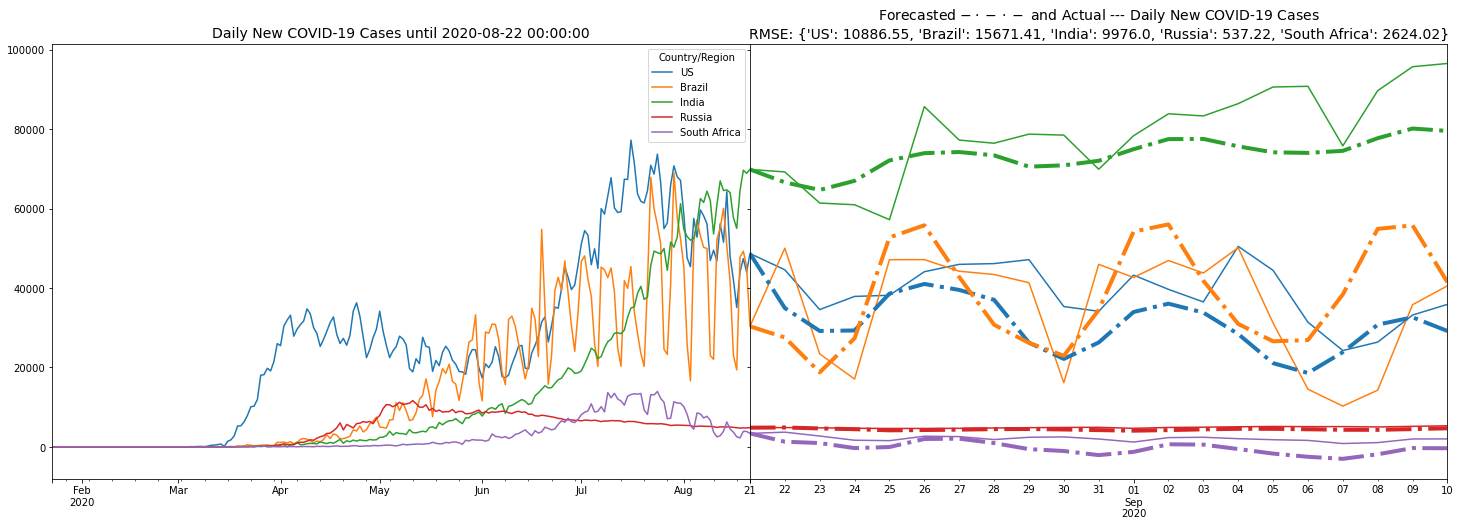

In [86]:
p, num_forecasts = 7, 20

stu_df = load_data()
_, forecasts = var_first_diff(stu_df, p, num_forecasts)
actual = pd.read_pickle("Data/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

stu_df.plot(ax=axes[0])

stu_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

stu_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * stu_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 Cases" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, stu_df, p, num_forecasts, forecasts, actual, rmse

let's compare the forecasts made by the VAR model(def var_first_diff) with that made by five independent AR(p) models (def aram_first_diff) for each time series. This way, we will be able to see the effect of including observations from possibly related time series on modelling each invidual time series more clearly.



In [87]:
def ar_first_diff(df, p, num_forecasts):
    """
    Fits an AR(p) model on the first-order diff on each time series in df and makes num_forecasts forecasts
    """
    
    forecast_dict = {}
    
    for col in df.columns:
        forecast_dict[col] = arma_first_diff(df[col], p, 0, num_forecasts)
    
    # Convert the forecasts to a DataFrame
    forecasts = pd.DataFrame(forecast_dict)
    
    
    return forecasts

We can now plot  the forecasts made by the five AR models. How does the RMSE for each time series compare with that caculated from the forecasts made by a single VAR model?

c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

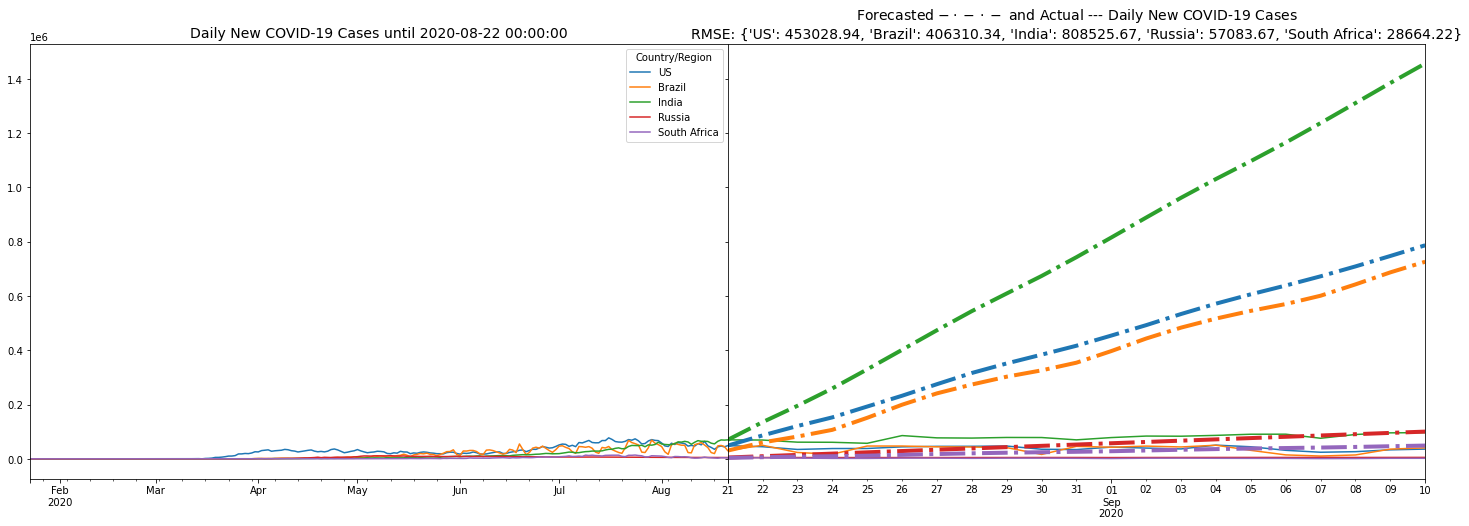

In [88]:
p, num_forecasts = 7, 20

stu_df = load_data()
forecasts = ar_first_diff(stu_df, p, num_forecasts)
actual = pd.read_pickle("Data/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

stu_df.plot(ax=axes[0])

stu_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

stu_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * stu_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 Cases" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, stu_df, p, num_forecasts, forecasts, actual, rmse

### Granger Causality
   The Granger Causality test is a statistical test for causality that works by determining whether the inclusion of one time series significantly improves the prediction of the other. Let's now perform a Granger Causality test on each pair of countries and see what we can conclude. 

In [89]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def test_granger(df, p):
    """
    Fits a VAR(p) model on the input df and performs pairwise Granger Causality tests
    """
    
    
    model = VAR(df.diff().dropna())
    result = model.fit(p)
    
    # Initialize the Granger Causality data frame
    granger_df = pd.DataFrame(np.nan, index=df.columns, columns=df.columns)
    
    
    for cause in df.columns:
        for caused in df.columns:
            if cause != caused:
                test_result = result.test_causality(caused, cause, kind='f')
                # Extract the p-value. The test result will have an attribute "pvalue".
                p_value = test_result.pvalue
                granger_df.loc[caused, cause] = p_value # do you understand this? 
    
    
    return granger_df

Now, let's show the causality matrix: if we believe the magic threshold of 0.01 or 0.05 for rejecting null hypothese. 

In [93]:
# Show the causality matrix

stu_df, p = load_data(), 7
stu_ans = test_granger(stu_df, 7)
caul_mtrx = stu_ans.rename(index={item: f"{item} caused by" for item in stu_ans.index})
caul_mtrx.where(caul_mtrx.isna(), caul_mtrx <= 0.01)


c:\Users\qfu88\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US caused by,NaN,True,False,False,False
Brazil caused by,False,NaN,True,False,True
India caused by,False,True,NaN,False,True
Russia caused by,True,False,False,NaN,False
South Africa caused by,False,False,False,False,NaN
